# Chapter3 ニューラルネットワークの基本
## 3. 糖尿病の予後予測【サンプルコード】

In [21]:
# 必要なパッケージのインストール
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

## 3.1. 糖尿病（Diabetes）データセット

In [22]:
# データセットのロード
diabetes = load_diabetes()

In [ ]:
for key, value in zip(diabetes.keys(), diabetes.values()):
    print(f"{key}:\n{value}\n")

In [ ]:
# データセットの説明
print(diabetes.DESCR)

In [ ]:
# データフレームに変換
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
# 1年後の進行度の追加
df['target'] = diabetes.target
print(df.head())

In [ ]:
# 基本統計量の確認
print(df.describe())

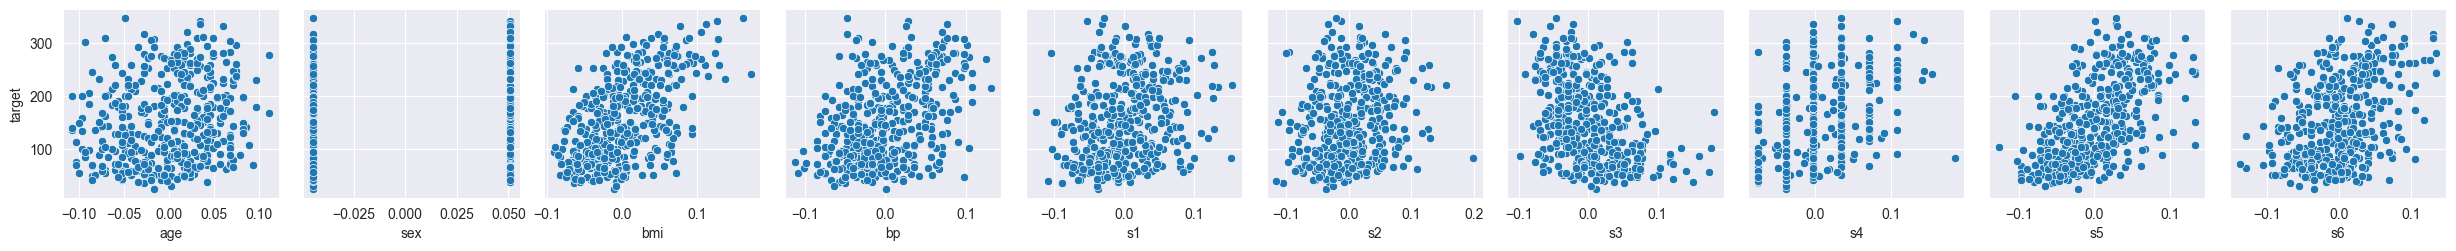

In [27]:
# データセットの可視化
sns.pairplot(df, x_vars=diabetes.feature_names, y_vars='target')
plt.show()

## 3.2. 前準備

In [ ]:
# データセットの読み込み
diabetes = load_diabetes()
data = diabetes.data  # 特徴量
label = diabetes.target.reshape(-1, 1)  # 一年後の糖尿病の進行度

# データセットのサイズの確認
print("data size: {}".format(data.shape))
print("label size: {}".format(label.shape))

## 3.3. 訓練データとテストデータの用意

In [ ]:
# 学習データとテストデータを分割
train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.2)

# 学習データとテストデータのサイズの確認
print("train_data size: {}".format(len(train_data)))
print("test_data size: {}".format(len(test_data)))
print("train_label size: {}".format(len(train_label)))
print("test_label size: {}".format(len(test_label)))

In [30]:
# ndarrayをPyTorchのTensorに変換
train_x = torch.Tensor(train_data)
test_x = torch.Tensor(test_data)
train_y = torch.Tensor(train_label)  # torch.float32のデータ型に
test_y = torch.Tensor(test_label)  # torch.float32のデータ型に

In [31]:
# 特徴量とラベルを結合したデータセットを作成
train_dataset = TensorDataset(train_x.to('mps'), train_y.to('mps'))
test_dataset = TensorDataset(test_x.to('mps'), test_y.to('mps'))

In [ ]:
# ミニバッチサイズを指定したデータローダーを作成
train_batch = DataLoader(
    dataset=train_dataset,  # データセットの指定
    batch_size=20,  # バッチサイズの指定
    shuffle=True,  # シャッフルするかどうかの指定
    num_workers=0)  # コアの数
test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=20,
    shuffle=False,
    num_workers=0)

# ミニバッチデータセットの確認
for data, label in train_batch:
    data = data.to('mps')  # データをGPUに送る
    label = label.to('mps')  # ラベルをGPUに送る
    print("batch data size: {}".format(data.size()))  # バッチの入力データサイズ
    print("batch label size: {}".format(label.size()))  # バッチのラベルサイズ
    break

## 3.4. ニューラルネットワークの定義

In [36]:
# ニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, H)  # 追加
        self.linear3 = nn.Linear(H, D_out)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))  # 追加
        x = F.relu(self.linear2(x))  # 追加
        x = self.dropout(x)  # 追加
        x = self.linear3(x)
        return x

In [37]:
# ハイパーパラメータの定義
D_in = 10    # 入力次元: 10
H = 200      # 隠れ層次元: 200
D_out = 1    # 出力次元: 1
epoch = 100  # 学習回数: 100

In [ ]:
# ネットワークのロード
# CPUとGPUどちらを使うかを指定
device = torch.device('mps')
net = Net(D_in, H, D_out).to(device)
# デバイスの確認
print("Device: {}".format(device))

## 3.5. 損失関数と最適化関数の定義

In [39]:
# 損失関数の定義
criterion = nn.MSELoss()  # 今回の損失関数（平均二乗誤差: MSE）
criterion2 = nn.L1Loss()  # 参考用（平均絶対誤差: MAE）

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())

## 3.6. 学習

In [ ]:
# 損失を保存するリストを作成
train_loss_list = []  # 学習損失（MSE）
test_loss_list = []  # 評価損失（MSE）
train_mae_list = []  # 学習MAE
test_mae_list = []  # 評価MAE

# 学習（エポック）の実行
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失の初期化
    train_loss = 0  # 学習損失（MSE）
    test_loss = 0  # 評価損失（MSE）
    train_mae = 0  # 学習MAE
    test_mae = 0  # 評価MAE

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    for data, label in train_batch:
        # GPUにTensorを転送
        data = data.to(device)
        label = label.to(device)

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred = net(data)
        # 損失（誤差）を計算
        loss = criterion(y_pred, label)  # MSE
        mae = criterion2(y_pred, label)  # MAE
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()
        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()  # MSE
        train_mae += mae.item()  # MAE

    # ミニバッチの平均の損失を計算
    batch_train_loss = train_loss / len(train_batch)
    batch_train_mae = train_mae / len(train_batch)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for data, label in test_batch:
            # GPUにTensorを転送
            data = data.to(device)
            label = label.to(device)
            # データを入力して予測値を計算（順伝播）
            y_pred = net(data)
            # 損失（誤差）を計算
            loss = criterion(y_pred, label)  # MSE
            mae = criterion2(y_pred, label)  # MAE
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()  # MSE
            test_mae += mae.item()  # MAE

    # ミニバッチの平均の損失を計算
    batch_test_loss = test_loss / len(test_batch)
    batch_test_mae = test_mae / len(test_batch)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失を表示
    print("Train_Loss: {:.4f} Train_MAE: {:.4f}".format(
        batch_train_loss, batch_train_mae))
    print("Test_Loss: {:.4f} Test_MAE: {:.4f}".format(
        batch_test_loss, batch_test_mae))
    # 損失をリスト化して保存
    train_loss_list.append(batch_train_loss)
    test_loss_list.append(batch_test_loss)
    train_mae_list.append(batch_train_mae)
    test_mae_list.append(batch_test_mae)

## 3.7. 結果の可視化

In [ ]:
# 損失（MSE）
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')
plt.legend()  # 凡例

# MAE
plt.figure()
plt.title('Train and Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(range(1, epoch+1), train_mae_list, color='blue',
         linestyle='-', label='Train_MAE')
plt.plot(range(1, epoch+1), test_mae_list, color='red',
         linestyle='--', label='Test_MAE')
plt.legend()  # 凡例

# 表示
plt.show()

In [ ]:
# 予測値と正解のプロット
plt.figure()
plt.title('Predicted and Correct')
plt.xlabel('Correct')
plt.ylabel('Predicted')
plt.legend()  # 凡例
# 表示
plt.show()
